# Unstructured data

## EXERCISE: SMS spam filtering with naive Bayes



References:
* http://sebastianraschka.com/Articles/2014_naive_bayes_1.html
* http://zacstewart.com/2015/04/28/document-classification-with-scikit-learn.html
* https://gist.github.com/zacstewart/5978000

Other options:
* https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html
* https://scikit-learn.org/0.18/datasets/rcv1.html

### Download data from UCI ML data repo

In [1]:
import os
import urllib.request
import zipfile

DATA_URI = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
DATA_DIR = 'data'
ARCHIVE_NAME = 'smsspamcollection.zip'
FILE_NAME = 'SMSSpamCollection'

# set up paths (in portable, OS-agnostic way)
local_archive_path = os.path.join(DATA_DIR, ARCHIVE_NAME)
local_file_path = os.path.join(DATA_DIR, FILE_NAME)

## set up local data directory
os.makedirs(DATA_DIR, exist_ok=True)

## save file from DATA_URI to local_path
urllib.request.urlretrieve(DATA_URI, local_archive_path)

## extract content from archive
z = zipfile.ZipFile(local_archive_path, 'r')
z.extractall(DATA_DIR)
z.close()

### Read and profile data using Pandas

Pandas provides tools that streamline some of the data analysis and visualisation work we've done in previous exercises. 

[DataFrame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe) is the most commonly used data structure in Pandas. It is a 2-dimensional labeled data structure with columns of potentially different types. You can think of it like a spreadsheet or SQL table.

Let's use it now to read and profile our spam data.

In [2]:
import csv
import pandas

messages = pandas.read_csv(local_file_path, sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])
print(messages)

# view aggregate statistics
messages.groupby('label').describe()

     label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5569  spam  This is the 2nd time we have tried 2 contact u...
5570   ham               Will ü b going to esplanade fr home?
5571   ham  Pity, * was in mood for that. So...any other s...
5572   ham  The guy did some bitching but I acted like i'd...
5573   ham                         Rofl. Its true to its name

[5574 rows x 2 columns]


message                                                               
        count unique                                                top freq
label                                                                       
ham      4827   4518                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

### Text feature extraction

- It's easy for humans to see the patterns that distinguish ham and spam messages. What kind of features could we feed to a machine learning algorithm?

Feeding raw text data (e.g., "Sorry, I'll call later") to a machine learning algorithm would not be very useful. As a first step let's assume that there is a systematic difference between the words used for spam and ham.

`scikit-learn` includes [several functions for creating feature vectors from text](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction). These first tokenise -- split strings into words (e.g., "Sorry", "I'll", "call", "later").

Then they create feature vectors where indices correspond to a specific word and values correspond to the frequency of the corresponding word. 

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# First split in to train and test sets
X_train, X_test, y_train, y_test = train_test_split(messages.message, messages.label, test_size=0.33,
                                                    random_state=5) # so we get the same results

# Fit and transform training to feature vectors of words
v = CountVectorizer(binary=True, lowercase=False)
X_train_bin = v.fit_transform(X_train)
print(X_train_bin.shape)

# scikit-learn vectorisers produce sparse array representations.
# These store only observed features for each instance instead of a complete vector.
# They're great for working with text data, but require a bit of work to inspect.

# View feature names
print('Feature names:\n', v.get_feature_names_out()[:10])

# View complete feature vector for a row as a list of words
def iter_features(X, row, names):
    for i in X[row].indices:
        yield names[i]
print('\nFeature words for row 1:\n', list(iter_features(X_train_bin, 1, v.get_feature_names_out())))

# Compare to original data
print('\nOriginal string for row 1:\n', X_train.iloc[1])

(3734, 8745)
Feature names:
 ['00' '000' '000pes' '008704050406' '0089' '0121' '01223585236'
 '01223585334' '0125698789' '02']

Feature words for row 1:
 ['Do', 'you', 'hide', 'anythiing', 'or', 'keeping', 'distance', 'from', 'me']

Original string for row 1:
 Do you hide anythiing or keeping distance from me


### Build pipelines and choose parameters

`scikit-learn` includes pipeline functionality that makes it possible to specify and optimise a sequence of actions.

Let's see whether the results in [Wang and Manning (2012)](http://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf) hold for the SMS spam data we're using here.

Specifically we will compare multinomial naive Bayes to support vector machine with a degree-2 polynomial kernel. We will choose the best feature representation for both:
* binary vs term frequency vs tfidf
* unigrams vs bigrams

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# Pipeline for multinomial naive Bayes
mnb = Pipeline([('vect', CountVectorizer(lowercase=False)),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())
               ])

# Pipeline for polynomial support vector machine
svm = Pipeline([('vect', CountVectorizer(lowercase=False)),
                ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC(C=0.1, penalty='l2', dual='auto'))
               ])

# Grid search parameters
param_grid = [{'vect__binary': [True, False],
               'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': [True, False]
              }]

# Find best parameters for MNB and SVM
gs_mnb = GridSearchCV(mnb, param_grid)
gs_mnb.fit(X_train, y_train)
print('\nMNB best params:\n', gs_mnb.best_params_)

gs_svm = GridSearchCV(svm, param_grid)
gs_svm.fit(X_train, y_train)
print('\nSVM best params:\n', gs_svm.best_params_)

# Print accuracy
print('\nMNB test result:\n', classification_report(y_test, gs_mnb.predict(X_test)))
print('\nSVM test result:\n', classification_report(y_test, gs_svm.predict(X_test)))


MNB best params:
 {'tfidf__use_idf': True, 'vect__binary': True, 'vect__ngram_range': (1, 1)}

SVM best params:
 {'tfidf__use_idf': False, 'vect__binary': False, 'vect__ngram_range': (1, 1)}

MNB test result:
               precision    recall  f1-score   support

         ham       0.95      1.00      0.98      1586
        spam       1.00      0.69      0.82       254

    accuracy                           0.96      1840
   macro avg       0.98      0.85      0.90      1840
weighted avg       0.96      0.96      0.95      1840


SVM test result:
               precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1586
        spam       0.98      0.75      0.85       254

    accuracy                           0.96      1840
   macro avg       0.97      0.88      0.92      1840
weighted avg       0.96      0.96      0.96      1840



### TODO Handling class imbalance with SVM

- Which is better? Do we care about overall performance or just one of our classes? How does this compare to Wang and Manning's result?
- The `fit()` method for `LinearSVC` includes the `class_weight` parameter with can help deal with imbalanced data. The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`. Train a new SVM model with the best grid search parameters and `class_weight='balanced'`. Is this result better?
- Is there a more appropriate scoring function we could pass to `GridSearchCV` (using `sklearn.metrics.make_scorer`)? Does this give different MNB or SVM results for the parameter grid above?

In [5]:
# TODO: replace the content of this cell with your Python solution
# raise NotImplementedError

# 1 - SVM gives a better result for spam, which is the category of interest.
#     Since it's the minority category in a binary problem,
#     we should be looking at precision and recall for spam only.

# 2 - Spam recall and f-score are better while precision is worse.
#     Which to deploy depends on the appropriate precision/recall tradeoff for users.
svm2 = Pipeline([('vect', CountVectorizer(lowercase=False, binary=False, ngram_range=(1,1))),
                 ('tfidf', TfidfTransformer(use_idf=False)),
                 ('clf', LinearSVC(C=0.1, penalty='l2', class_weight='balanced', dual='auto'))
                ])
svm2.fit(X_train, y_train)
print('\nSVM2 test result:\n', classification_report(y_test, svm2.predict(X_test)))

# 3 - We can use `f1_score` with `pos_label='spam'` and `average='binary'`.
#     This gives the same results for this parameter grid, but could be used to choose the best `class_weight`.
#     Note with f1_score, we could also specify whether we prefer precision or recall.
from sklearn.metrics import make_scorer, f1_score
f1_scorer = make_scorer(f1_score, pos_label='spam', average='binary')
gs_mnb2 = GridSearchCV(mnb, param_grid, scoring=f1_scorer)
gs_mnb2.fit(X_train, y_train)
print('\nMNB GS2 best params:\n', gs_mnb2.best_params_)

gs_svm2 = GridSearchCV(svm, param_grid, scoring=f1_scorer)
gs_svm2.fit(X_train, y_train)
print('\nSVM GS2 best params:\n', gs_svm2.best_params_)

print('\nMNB GS2 test result:\n', classification_report(y_test, gs_mnb2.predict(X_test)))
print('\nSVM GS2 test result:\n', classification_report(y_test, gs_svm2.predict(X_test)))


SVM2 test result:
               precision    recall  f1-score   support

         ham       0.99      0.98      0.99      1586
        spam       0.90      0.94      0.92       254

    accuracy                           0.98      1840
   macro avg       0.95      0.96      0.95      1840
weighted avg       0.98      0.98      0.98      1840


MNB GS2 best params:
 {'tfidf__use_idf': True, 'vect__binary': True, 'vect__ngram_range': (1, 1)}

SVM GS2 best params:
 {'tfidf__use_idf': False, 'vect__binary': False, 'vect__ngram_range': (1, 1)}

MNB GS2 test result:
               precision    recall  f1-score   support

         ham       0.95      1.00      0.98      1586
        spam       1.00      0.69      0.82       254

    accuracy                           0.96      1840
   macro avg       0.98      0.85      0.90      1840
weighted avg       0.96      0.96      0.95      1840


SVM GS2 test result:
               precision    recall  f1-score   support

         ham       0.96  

### OPTIONAL Generalisation, data size, features

- Plot training vs generalisation error by number of features (using the `max_features` option to CountVectorizer). Should we use fewer features?
- Plot training vs generalisation error by amount of training data. Would it be worth obtaining more training data?
- What other features could we use?

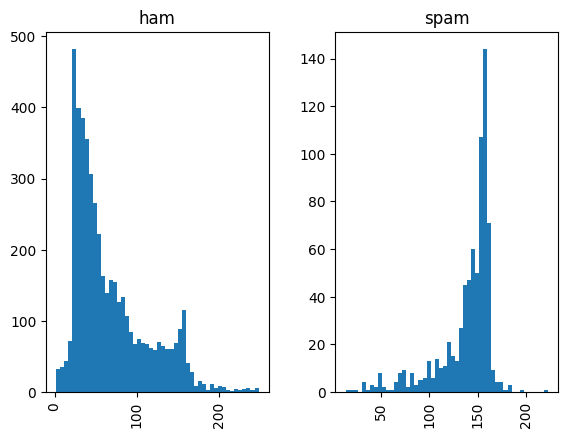

In [6]:
# TODO: replace the content of this cell with your Python solution
# raise NotImplementedError

# 1 - Refer to week 10 exercise.

# 2 - Refer to week 10 exercise.

# 3 - We haven't done anything to normalise our word features.
#     We could convert everything to lowercase and stem or lemmatise.
#     Character n-gram features might pick up common spam strings (e.g., "XXX")
#     Capitalisation patterns might help distiguish, e.g., spam 
#     might use upper case more.
#     Message length would help distinguish for this data set (see plot), but
#     may not generalise.
#     It's worth noting as well that this sample may not be particularly
#     representative of the population of SMS messages since it
#     was collected from several specific subpopulations
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
messages['length'] = messages['message'].map(lambda text: len(text))
_ = messages[messages.length<=250].hist(column='length', by='label', bins=50)

## EXERCISE: Forecasting movie gross with support vector regression

Imagine you have an opportunity to invest in films after seeing descriptions. Perhaps you run a cinema and need to decide which films to show. If we could predict box office gross based on descriptions, then we'd have a good basis for investment decisions.

In this exercise we'll predict movie gross with support vector regression. 

### Download reviews and movie gross data

DBPedia converts Wikipedia pages into structured semantic web data. Let's use it to grab the data we need. DBpedia has a public SPARQL endpoint at http://dbpedia.org/sparql. Enter the following query and save as `CSV` under `Results Format` and click `Run Query`.

#### Query
```
PREFIX category: <http://dbpedia.org/resource/Category:>
PREFIX dbtype: <http://dbpedia.org/datatype/>
PREFIX dcterms: <http://purl.org/dc/terms/>

SELECT ?dburl ?title ?budget ?gross ?abstract
WHERE { 
 ?dburl dcterms:subject category:2013_films .

 ?dburl foaf:name ?title .
 FILTER(LANG(?title) = "en") .

 ?dburl dbo:budget ?budget .
 FILTER(xsd:float(?budget) > xsd:float("1.0E7")) .
 FILTER(datatype(?budget) = dbtype:usDollar) .

 ?dburl dbo:gross ?gross .
 FILTER(datatype(?gross) = dbtype:usDollar) .

 ?dburl dbo:abstract ?abstract .
 FILTER(LANG(?abstract) = "en") .
 FILTER(fn:string-length(?abstract) >= xsd:int(140)) .
} 
```

This will return the box office gross and the Wikipedia abstract for English films from 2013 that had a USD budget of more than 10 million. This will be our training data. Upload to your `data` directory on Jupyter Hub and rename to `movies.2013.csv`.

Run the same query with `category:2014_films` to get test data. Upload to your `data` directory on Jupyter Hub and rename to `movies.2014.csv`.

In [7]:
import csv
import os

TRAIN_NAME = 'movies.2013.csv'
TEST_NAME = 'movies.2014.csv'

def read_movies(path):
    data = []
    target = []
    for d in csv.DictReader(open(path,encoding="utf8")):
        data.append(d['abstract'])
        target.append(float(d['gross']))
    return data, target

train_path = os.path.join('data', TRAIN_NAME)
X_train, y_train = read_movies(train_path)
print(len(X_train), len(y_train))

test_path = os.path.join('data', TEST_NAME)
X_test, y_test = read_movies(test_path)
print(len(X_test), len(y_test))

162 162
144 144


### Select parameters for support vector regression

Let's see whether the results in [Kogan et al. (2009)](http://www.cs.cmu.edu/~nasmith/papers/kogan+levin+routledge+sagi+smith.naacl09.pdf) hold for the movie gross data we're using here.

Specifically we will choose the best feature representation for both:
* binary vs term frequency vs tfidf
* unigrams vs bigrams

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

svr = Pipeline([('vect', CountVectorizer(lowercase=True)),
                ('tfidf', TfidfTransformer()),
                ('clf', LinearSVR(epsilon=0.1))
               ])

# Grid search parameters
param_grid = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__binary': [True, False],
              'tfidf__use_idf': [True, False],
              'tfidf__sublinear_tf': [True, False],
              'clf__C': [1e8, 1e9],
             }

# Find best parameters
gs_svr = GridSearchCV(svr, param_grid)
gs_svr.fit(X_train, y_train)
print('Grid search mean and stdev:\n')

scoring = gs_svr.cv_results_
for mean_score, std, params in zip(scoring['mean_test_score'],scoring['std_test_score'],scoring['params']):
    print("{:0.3f} (+/-{:0.03f}) for {}".format(
            mean_score, std * 2, params))

print('\nSVR best params:\n', gs_svr.best_params_)
print('\nSVR r-squared on training data:\n', gs_svr.score(X_train, y_train))
print('\nSVR r-squared on test data:\n', gs_svr.score(X_test, y_test))

### TODO Evaluation and discussion

- Draw a residual plot with training data in blue and test data in green (like we did in week 9). Is a linear model appropriate for our data? Is prediction performance comparable to training performance?
- How could we improve this experimental setup? We can use `gs_svr.steps` to access feature names (`vect.get_feature_names_out()`) and weights (`clf.coef_`) from the pipeline components respectively. Use Python `zip` function to combine and sort these. What do the highest-weighted features tell us about our experimental setup?
- Would you use this model to pick investments?
- Maybe we're not predicting the right thing. What derived values could we predict? If you have time to try them, are they better?
- Is there other text data that might be a better predictor of box office returns?

In [ ]:
# TODO: replace the content of this cell with your Python solution
# raise NotImplementedError

# 1 - Training residuals are nearly zero for most movies with a few exceptions.
#     This may indicate overfitting. The residual plot for test data is OK.
%matplotlib inline
import matplotlib.pyplot as plt
print('Residual plot for training data (blue) and test data (green) below')
plt.scatter(gs_svr.predict(X_train), y_train-gs_svr.predict(X_train), c='blue', s=40, alpha=0.5, edgecolor='white')
plt.scatter(gs_svr.predict(X_test), y_test-gs_svr.predict(X_test), c='green', s=40, alpha=0.5, edgecolor='white')
plt.plot([-10,50], [0,0], c='black')
plt.ylabel('Residuals ($y - \hat{y}$)')
plt.xlabel('Predicted values ($\hat{y}$)')

# 2 - More data!!!
#     It would be better to have another chunk of data, e.g., from 2012.
#     Then we could train on 2012 and tune our parameters on 2013.
#     2014 could then serve as a final held-out test set to evaluate generalisation.
#     It may be better to predict return / budget instead of the raw return value.
#     We should also compare to a baseline model, e.g., using budget to predict gross return.
#     Wikipedia is a bad source of descriptions for our scenario, since it is constantly
#     edited and so we have data leakage. We could use the version of the Wikipedia
#     abstract from when the movie was released.
#     Printing the highest-weighted features highlights issues of data leakage..
steps = dict(gs_svr.best_estimator_.steps) # access pipeline components directly
import pprint
vect = steps['vect'] # vectorizer component
clf = steps['clf'] # classifier component
feature_weights = clf.coef_
feature_names = vect.get_feature_names_out()
# print top 20 features
print('\nTop 20 features:')
pprint.pprint(sorted(zip(feature_weights, feature_names), reverse=True)[:20])

# 3 - No way would I deploy. The data leakage here means we can't trust this experiment setup.

# 4 - We could try the ratio of gross to budget, then multiply a prediction by
#     budget to get predicted gross.

# 5 - Reviews, e.g., from Metacritic or Rotten Tomatoes.
#     Here it would be good to compare to a baseline that predicts gross based on star ratings.

# End of Tutorial. Many Thanks.